# Выбор оптимальной локации для нефтяной скважины

Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 
Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль и проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных:**

Данные геологоразведки трёх регионов находятся в файлах: 
* `/datasets/geo_data_0.csv`
* `/datasets/geo_data_1.csv`
* `/datasets/geo_data_2.csv`

Содержат следующие признаки:

* **id** — уникальный идентификатор скважины;
* **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
* **product** — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
    
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### Импортируем необходимые библиотеки

In [1]:
# библиотека для работы с данными
import pandas as pd
# библиотека для создания графиков
import matplotlib.pyplot as plt
# функция для создания легенды на графиках
from matplotlib.patches import Patch
# библиотека для визуализации данных
import seaborn as sns
# библиотека для работы с массивами и матрицами
import numpy as np

# функция для разделения данных на обучающий и тестовый наборы
from sklearn.model_selection import train_test_split

# классы для подготовки данных
from sklearn.preprocessing import (
    # для стандартизации признаков
    StandardScaler,    
)
# класс для объединения преобразований признаков
from sklearn.compose import ColumnTransformer


# функция для работы с метрикой из sklearn.metrics
from sklearn.metrics import mean_squared_error     

# модели из sklearn для построения классификаторов и регрессоров
# логистическая регрессия
from sklearn.linear_model import LogisticRegression
# линейная регрессия
from sklearn.linear_model import LinearRegression

# задаём значение констант
# для воспроизводимости результатов
RANDOM_STATE = 42

# задаём стиль для графиков
sns.set_style("darkgrid")

# Импорт os для работы с операционной системой
import os

# игнорируем предупреждения
import warnings
warnings.simplefilter("ignore")

## Загрузка и подготовка данных

### Загрузим данные

Считаем CSV-файлы в датафреймы

In [2]:
local_path = '/datasets/'
online_path = 'https://xxx/datasets/'

files = [
    'geo_data_0.csv',
    'geo_data_1.csv',
    'geo_data_2.csv'
]

dfs = []

# Чтение файлов и создание датафреймов
for file_name in files:
    local_file_path = local_path + file_name
    online_file_path = online_path + file_name
    try:
        if os.path.exists(local_file_path):
            # Получение имени датафрейма из имени файла
            df_name = file_name.split('.')[0]  
            df = pd.read_csv(local_file_path)
            print(f"Данные загружены из локальной директории: {file_name}")
        elif os.path.exists(online_file_path):
            # Получение имени датафрейма из имени файла
            df_name = file_name.split('.')[0]  
            df = pd.read_csv(online_file_path)
            print(f"Данные загружены из сети: {file_name}")
        # Присвоение датафрейму имени    
        globals()[df_name] = df  
        df.name = df_name
        # Добавление датафрейма в список dfs   
        dfs.append(df)           
    except Exception as e:
        print(f"Произошла ошибка при чтении файла {file_name}: {e}")

Данные загружены из локальной директории: geo_data_0.csv
Данные загружены из локальной директории: geo_data_1.csv
Данные загружены из локальной директории: geo_data_2.csv


In [3]:
# задаём целевой признак
target = 'product'

### Просмотрим информацию о датафреймах

Напишем функцию для просмотра информации о датафреймах

In [4]:
def info_func(df):
    '''
    функция для просмотра характеристик датафреймов, 
    проверки наличия пропусков и дубликатов в данных
    функция info_func принимает на вход DataFrame df и выводит первые несколько строк 
    этого DataFrame, а также общую информацию о нем, количество пустых значений
    и количество явных дубликатов в этом DataFrame.

    Parameters:
    df (DataFrame): Исходный DataFrame, для которого требуется вывести информацию.
    target: Целевой признак

    Returns:
    None: Функция не возвращает значений, она лишь выводит информацию о DataFrame.
    '''
    print('-'*22,'Исходный датафрейм', df.name, '-'*22)
    display(df.head())
    print('')
    print('')
    print('-'*12,'Общая информация о датафрейме', df.name,'-'*12)
    print('')
    print('')
    display(df.info())
    
    print('-'*10,'Количество пустых значений в датафрейме',df.name,'-'*10)
    print('')
    print('')
    display(df.isna().sum())
    print('-'*10,'Количество явных дубликатов в датафрейме',df.name,'-'*10)
    display(df.duplicated().sum())
        
    dup_id = df['id'].value_counts()
    print('-'*10,'Количество неявных дубликатов в датафрейме', df.name, ' в столбце id','-'*10)
    print(len(df) - dup_id.count())
    name = df.name
    df = df.drop_duplicates(subset='id', keep=False)
    df.name = name 
    
    print('-'*10,'Графики распределения признаков датафрейма',df.name,'-'*10)
    # Построение графиков распределения
    num_cols = df.select_dtypes(include=['number']).columns
    n_cols = 2
    n_rows = (len(num_cols) + n_cols - 1) // n_cols  # Вычисление количества строк

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Преобразование массива осей в одномерный массив

    for i, col in enumerate(num_cols):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Распределение признака: {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Частота')
        axes[i].grid(True)

    # Удаление пустых подграфиков
    for i in range(len(num_cols), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    
    print('-'*10,'Матрица корреляции признаков датафрейма',df.name,'-'*10)
    
    # Вычисление матрицы корреляции
    corr_matrix = df.corr()

    # Построение тепловой карты корреляционной матрицы
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
    plt.title('Матрица корреляции признаков')
    plt.show()

Применим к датафреймам функцию `info_func`

---------------------- Исходный датафрейм geo_data_0 ----------------------


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647




------------ Общая информация о датафрейме geo_data_0 ------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------- Количество пустых значений в датафрейме geo_data_0 ----------




id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

---------- Количество явных дубликатов в датафрейме geo_data_0 ----------


0

---------- Количество неявных дубликатов в датафрейме geo_data_0  в столбце id ----------
10
---------- Графики распределения признаков датафрейма geo_data_0 ----------


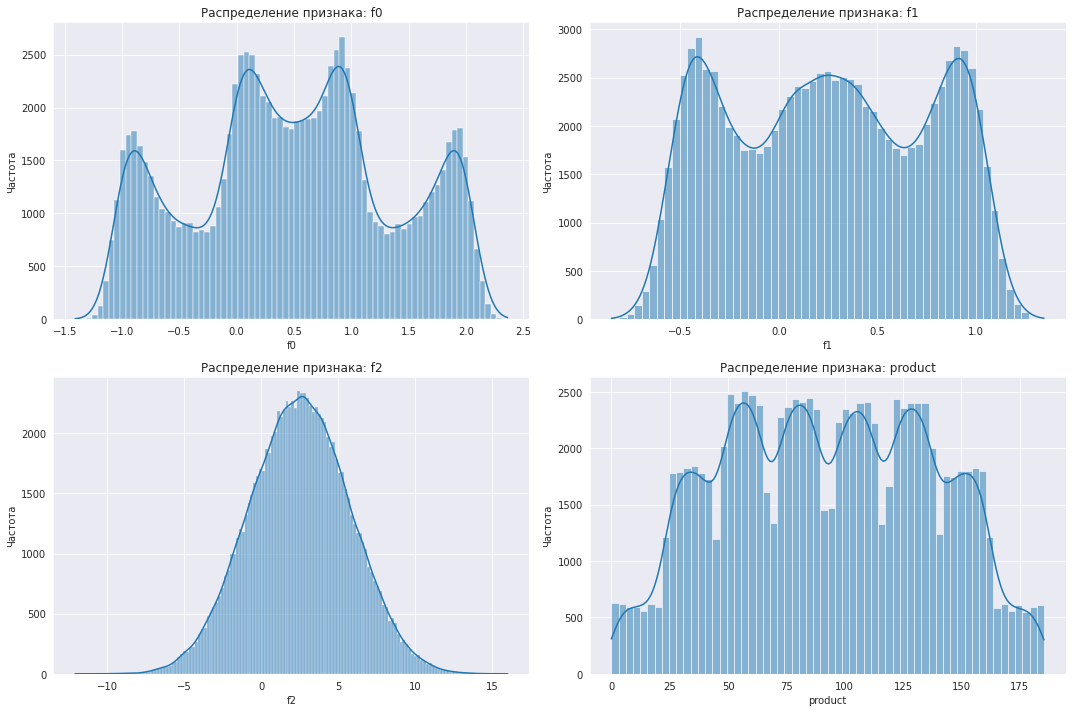

---------- Матрица корреляции признаков датафрейма geo_data_0 ----------


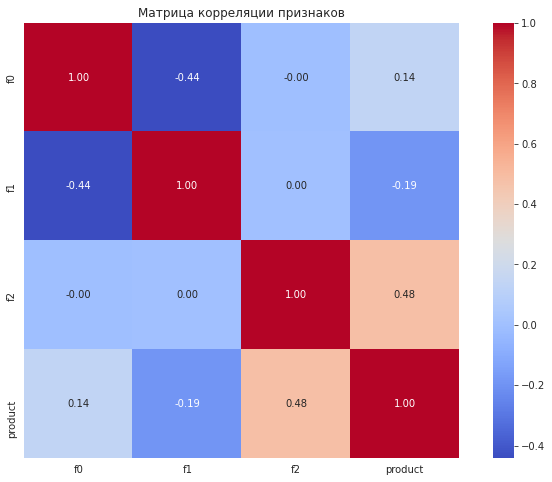

---------------------- Исходный датафрейм geo_data_1 ----------------------


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305




------------ Общая информация о датафрейме geo_data_1 ------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------- Количество пустых значений в датафрейме geo_data_1 ----------




id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

---------- Количество явных дубликатов в датафрейме geo_data_1 ----------


0

---------- Количество неявных дубликатов в датафрейме geo_data_1  в столбце id ----------
4
---------- Графики распределения признаков датафрейма geo_data_1 ----------


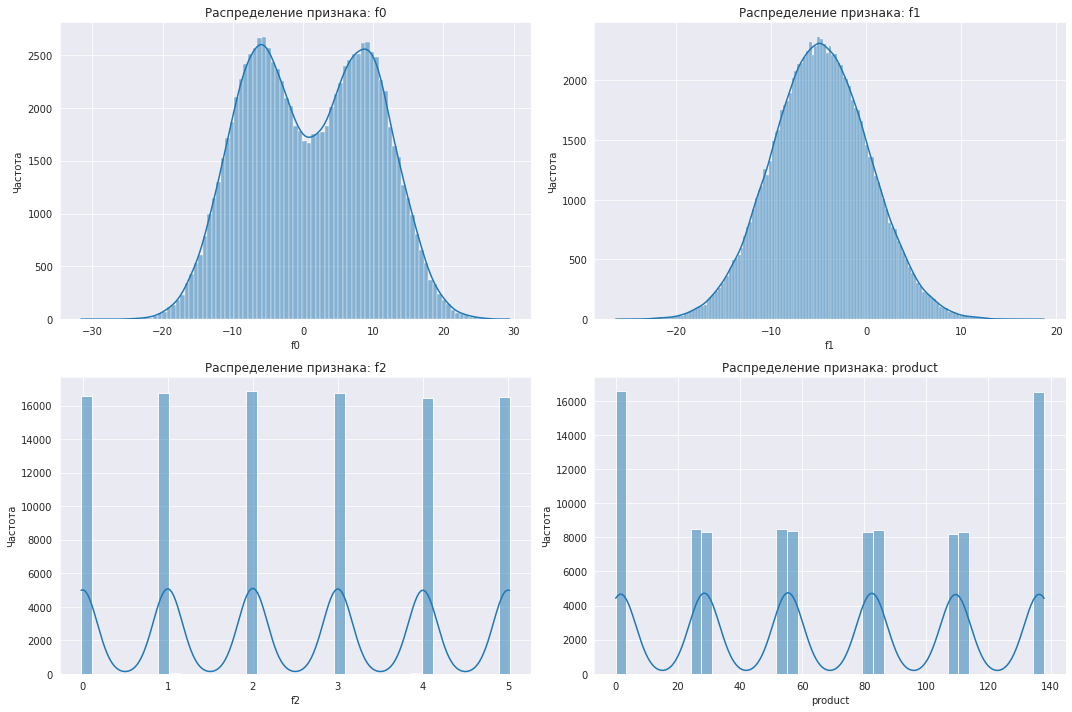

---------- Матрица корреляции признаков датафрейма geo_data_1 ----------


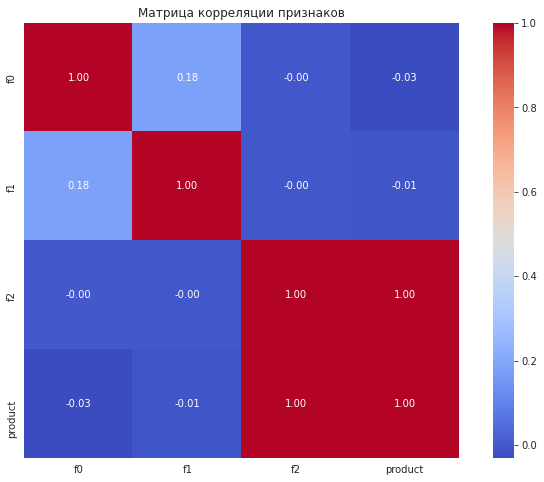

---------------------- Исходный датафрейм geo_data_2 ----------------------


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746




------------ Общая информация о датафрейме geo_data_2 ------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------- Количество пустых значений в датафрейме geo_data_2 ----------




id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

---------- Количество явных дубликатов в датафрейме geo_data_2 ----------


0

---------- Количество неявных дубликатов в датафрейме geo_data_2  в столбце id ----------
4
---------- Графики распределения признаков датафрейма geo_data_2 ----------


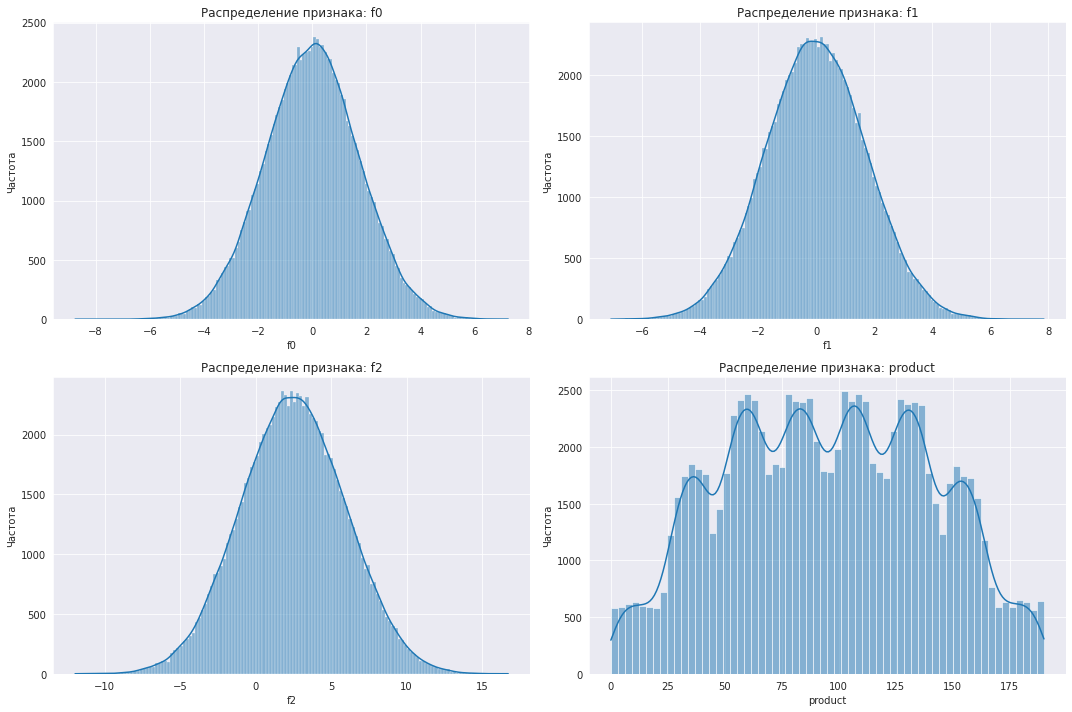

---------- Матрица корреляции признаков датафрейма geo_data_2 ----------


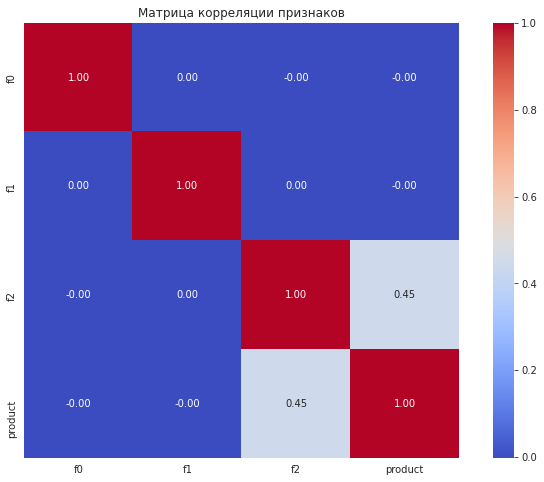

In [5]:
for df in dfs:
    info_func(df)

* Каждый датафрейм содержит 100 000 строк, данные соответствуют описанию
* Пропущенные значения и явные дубликаты отсутствуют
* Удалено неявных дубликатов в датафреймах:
 * `geo_data_0.csv` - 10
 * `geo_data_1.csv` - 4
 * `geo_data_2.csv` - 4

В регионе `geo_data_1` наблюдается не нормальное распределение признаков, целевой признак коррелирует с признаком `f2` на 100%

### Подготовка данных

Переенесём столбец id в индексы, он не требуется для обучения моделей

In [6]:
print(f'Количество явных дубликатов для:')
for df in dfs:
    df.set_index('id', inplace=True)
    print(f'                                 {df.name} - {df.duplicated().sum()}')

Количество явных дубликатов для:
                                 geo_data_0 - 0
                                 geo_data_1 - 0
                                 geo_data_2 - 0


In [7]:
features = ['f0','f1','f2']

## Обучение и проверка модели

Напишем функцию для обучения и проверки модели

In [8]:
def model_tr(df, target, features):
    # Разобьём данные на тренировочную и валидационную выборки

    X = df[features]
    y = df[target]

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, 
        y,
        test_size=.25,
        random_state=RANDOM_STATE)
    
    # Выберем метод масштабирования
    scaler = StandardScaler()

    # Настрока масштабирования на тренировочной выборке
    scaler.fit(X_train[features])

    # Масштабирование тренировочной выборки 
    X_train_scaled = scaler.transform(X_train[features])

    # Масштабирование валидационной выборки 
    X_valid_scaled = scaler.transform(X_valid[features])
    
    # создадим тренировочный и валидационный датафреймы из отмасштабированных данных
    X_train = pd.DataFrame(X_train_scaled, columns=features)
    X_valid = pd.DataFrame(X_valid_scaled, columns=features)
    
    # Объявим модель
    model = LinearRegression()

    # Обучим модель
    model.fit(X_train, y_train)

    # Получим предсказания
    pred = model.predict(X_valid)
    
    print(f'Средний запас сырья в {df.name}: {pred.mean():.2f}')
    print(f'RMSE модели: {mean_squared_error(y_valid, pred, squared=False):.2f}')
    
    df_result = pd.DataFrame([], columns=['cor', 'pred'])
    df_result['cor'] = y_valid
    df_result['pred'] = pred
    
    return df_result

Применим функцию для обучения моделей `model_tr`

In [9]:
df_0 = model_tr(geo_data_0, target, features)

Средний запас сырья в geo_data_0: 92.40
RMSE модели: 37.76


In [10]:
df_1 = model_tr(geo_data_1, target, features)

Средний запас сырья в geo_data_1: 68.71
RMSE модели: 0.89


In [11]:
df_2 = model_tr(geo_data_2, target, features)

Средний запас сырья в geo_data_2: 94.77
RMSE модели: 40.15


Средний запас сырья и RMSE модели больше всего в регионе `geo_data_2` - 94.77, меньше всего в регионе `geo_data_1` 68.71

## Подготовка к расчёту прибыли

### Зададим константы для ключевых значений

In [12]:
POINTS_COUNT_EXAMINED = 500
POINTS_COUNT_BEST = 200
BUDGET = 10_000_000_000
INCOME_FROM_ONE_UNIT = 450000

### Рассчитаем достаточный объём сырья для безубыточной разработки разработки новой скважины

In [13]:
print(f'Объём сырья для безубыточной разработки должен составлять не менее: \
      {BUDGET/POINTS_COUNT_BEST/INCOME_FROM_ONE_UNIT:.2f},тыс.баррелей')

Объём сырья для безубыточной разработки должен составлять не менее:       111.11,тыс.баррелей


Самый высокий средний запас сырья в регионе `geo_data_2` составляет 94.77, что меньше необходимого для безубыточной разработки новой скважины объема в 111.11. Поскольку средние запасы сырья по всем регионам недостаточны для безубыточной разработки, необходимо выбирать скважины с максимальными запасами.

### Напишем функцию для рассчёта прибыли по выбранным скважинам и предсказаниям модели

In [14]:
def calculate_revenue(predictions, target, count):
    """
    Функция для расчета прибыли от выбранных скважин.
    
    Parameters:
    predictions (array-like): предсказания модели.
    target (array-like): целевые значения (истинные запасы).
    count (int): количество лучших скважин для разработки.
    
    Returns:
    profit (float): прибыль от выбранных скважин.
    """
    # Создадим DataFrame из предсказаний и целевых значений
    data = pd.DataFrame({
        'prediction': predictions,
        'target': target
    })

    # Сбросим индексы для избегания дубликатов
    data = data.reset_index(drop=True)

    # Отсортируем по предсказаниям
    data_sorted = data.sort_values(by='prediction', ascending=False)

    # Возьмем только первые `count` значений
    selected = data_sorted.head(count)

    # Расчет прибыли
    total_revenue = selected['target'].sum() * INCOME_FROM_ONE_UNIT
    profit = total_revenue - BUDGET

    return profit

## Расчёт прибыли и рисков 

In [15]:
def analyze_region(df, target, features, n_bootstraps=1000):
    """
    Функция для анализа региона: обучение модели, выполнение бутстрап и расчет прибыли и рисков.
    
    Parameters:
    df (DataFrame): данные региона.
    target (str): название столбца с целевыми значениями.
    features (list): список названий столбцов с признаками.
    n_bootstraps (int): количество бутстрап-итераций.
    
    Returns:
    profits (array): массив значений прибыли для каждой итерации бутстрап.
    mean_profit (float): средняя прибыль.
    risk (float): вероятность убытков.
    """
    # Обучим модель и получим предсказания
    result = model_tr(df, target, features)
    predictions = result['pred']
    true_values = result['cor']
    
    # Создадим DataFrame из предсказаний и целевых значений
    data = pd.DataFrame({
        'prediction': predictions,
        'target': true_values
    })

    # Выполним бутстрап и расчет прибыли
    profits = []
    for i in range(n_bootstraps):
        # Выполним бутстрап с возвращением
        sample = data.sample(n=POINTS_COUNT_EXAMINED, replace=True, random_state=RANDOM_STATE+i)
        sample_predictions = sample['prediction']
        sample_target = sample['target']
        
        # Рассчитаем прибыль для текущей выборки
        profit = calculate_revenue(sample_predictions, sample_target, POINTS_COUNT_BEST)
        profits.append(profit)
        
    profits = np.array(profits)
    
    # Расчитаем среднюю прибыль и риски
    mean_profit = profits.mean()
    lower_bound = np.percentile(profits, 2.5)
    upper_bound = np.percentile(profits, 97.5)
    risk = (profits < 0).mean()
    
    # Вывод результатов
    print(f'Средняя прибыль в регионе {df.name}: {mean_profit/1000000:.2f} млн. руб.')
    print(f'95%-ный доверительный интервал: от {lower_bound/1000000:.2f} до {upper_bound/1000000:.2f} млн. руб.')
    print(f'Риск убытков: {risk * 100:.2f}%')
    
    return profits, mean_profit, risk

In [16]:
# Выполним анализ для каждого региона
for df in dfs:
    print(f'\nАнализ региона: {df.name}')
    analyze_region(df, target, features)


Анализ региона: geo_data_0
Средний запас сырья в geo_data_0: 92.40
RMSE модели: 37.76
Средняя прибыль в регионе geo_data_0: 404.12 млн. руб.
95%-ный доверительный интервал: от -79.94 до 933.66 млн. руб.
Риск убытков: 5.80%

Анализ региона: geo_data_1
Средний запас сырья в geo_data_1: 68.71
RMSE модели: 0.89
Средняя прибыль в регионе geo_data_1: 442.00 млн. руб.
95%-ный доверительный интервал: от 54.34 до 812.36 млн. руб.
Риск убытков: 1.40%

Анализ региона: geo_data_2
Средний запас сырья в geo_data_2: 94.77
RMSE модели: 40.15
Средняя прибыль в регионе geo_data_2: 376.54 млн. руб.
95%-ный доверительный интервал: от -144.75 до 909.00 млн. руб.
Риск убытков: 8.40%


**Вывод**

Исходя из анализа трех регионов для разработки новой скважины, следует сделать следующие выводы:

1. **Средний запас сырья:** Самый высокий средний запас сырья наблюдается в регионе `geo_data_2` и составляет 94.77 тыс. баррелей, в то время как в регионе `geo_data_1` этот показатель значительно ниже и составляет 68.71 тыс. баррелей.

2. **Прогнозная точность модели:** Модель линейной регрессии показывает наилучшие результаты в регионе `geo_data_1`, где среднеквадратичная ошибка составляет всего 0.89 тыс. баррелей. В других регионах ошибка немного выше: 37.76 тыс. баррелей для `geo_data_0` и 40.15 тыс. баррелей для `geo_data_2`.

3. **Прибыль и риски:** Риск убытков наибольший в регионе `geo_data_2` и составляет 8.4%, что выше установленного порога в 2.5%. В регионах `geo_data_0` и `geo_data_1` риск убытков составляет 5.8% и 1.4% соответственно.

4. **Предполагаемая прибыль:** Средняя прибыль от разработки скважин ожидается наибольшей в регионе `geo_data_1` и составляет 442 млн. рублей, с 95%-ным доверительным интервалом от 54.34 до 812.36 млн. рублей. Средняя прибыль в регионе `geo_data_2` составляет 376.54 млн. рублей, но при этом существует риск убытков, так как нижняя граница доверительного интервала отрицательная (-144.75 млн. рублей).

Исходя из анализа, регион `geo_data_1` представляется наиболее предпочтительным для разработки новой скважины, так как он обладает хорошим средним запасом сырья, низким риском убытков и достаточно точной моделью прогнозирования.